# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](Need to update this).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload

In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

In [452]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [453]:
# Show df to get an idea of the data
df

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45989,142.0,neural networks for beginners: popular types a...,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45990,233.0,bayesian nonparametric models – stats and bots,4faeed980a7cd11e0f3cf2058cc04daa2ef11452
45991,1160.0,analyze accident reports on amazon emr spark,abbf639ba05daa5249c520e290283a6d726ba78d


In [454]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [455]:
# Show df_content to get an idea of the data
df_content

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
...,...,...,...,...,...
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [456]:
df['email'].value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

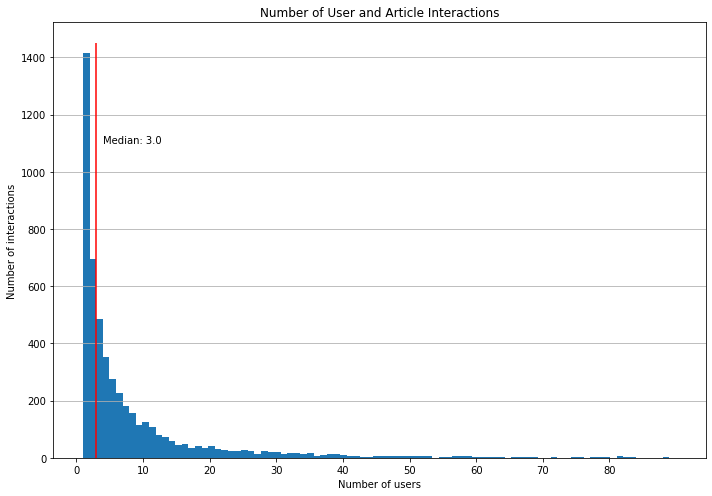

In [457]:
median = df['email'].value_counts().median()
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Number of User and Article Interactions')
plt.xlabel('Number of users')
plt.ylabel('Number of interactions')
ax.set_xticks(np.arange(0,90,10))
ax.set_yticks(np.arange(0,1450,200))
ax.hist(df['email'].value_counts(), bins=90, range=(1,90))
ax.grid(which='major', axis='y')
plt.vlines(x=median, ymin = 0, ymax =1450, color='red')
plt.annotate(xy=(median+1, 1100), s=f'Median: {median}')
fig.tight_layout()

In [458]:
# Fill in the median and maximum number of user_article interactios below

median_val = df['email'].value_counts().median() # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = df['email'].value_counts().max() # The maximum number of user-article interactions by any 1 user is 364.
display(median_val, max_views_by_user)

3.0

364

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [459]:
# Find and explore duplicate articles
df_content['article_id'].duplicated().sum() #number of duplicated articles
df_content[df_content['article_id'].duplicated()] #print the duplicated articles

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [460]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset = ['article_id'])

In [461]:
#check to make sure drop duplicates worked
df_content['article_id'].duplicated().sum()

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br> 
**d.** The number of user-article interactions in the dataset.

In [462]:
unique_articles = df.article_id.nunique()# The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique()# The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = len(df) # The number of user-article interactions

In [463]:
print (('a. {} \nb. {} \nc. {} \nd. {}  ').format(unique_articles, 
                                                   total_articles,
                                                   unique_users,
                                                   user_article_interactions))

a. 714 
b. 1051 
c. 5148 
d. 45993  


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was find using other information that all of these null values likely belonged to a single user.

In [464]:
df.groupby(['article_id'])['email'].count().sort_values(ascending=False)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
1233.0      1
1237.0      1
417.0       1
984.0       1
1092.0      1
Name: email, Length: 714, dtype: int64

In [465]:
most_viewed_article_id =  '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [466]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [467]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [559]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_list = list(df['article_id'].value_counts().head(n=n).index)
    #top_articles = list(df.loc[top_list]['title'].values) uses index as article id, will only work if replace index with article id
    top_articles = df.loc[df['article_id'].isin(top_list)]['title'].unique().tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_article_ids = df['article_id'].value_counts().head(n=n).index.to_list()
 
    return top_article_ids # Return the top article ids

In [469]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [470]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [23]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df_to_zip = df[['article_id', 'user_id']].drop_duplicates() #slice df of just article id and user id without duplicates
    user_item_mat = pd.DataFrame(index = df.user_id.unique(), columns=sorted(df.article_id.unique()), data=0) #create the empty matrix with 0's
    for article_id, user_id in zip(df_to_zip['article_id'], df_to_zip['user_id']): #add 1's to the matrix for each intersection in the df from each pair of article id and user id
        user_item_mat[article_id][user_id] = 1
    
    return user_item_mat # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [24]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [153]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])
    
    #remove the own user's id
    similarity = similarity.drop(user_id) 
    
    # sort by similarity
    similarity = similarity.sort_values(ascending = False)
    
    #create list of just the ids
    most_similar_users = similarity.index.tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [131]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [485]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = df.loc[df['article_id'].isin(article_ids)]['title'].unique().tolist()
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    user_articles = user_item.loc[user_id]
    article_ids = user_articles[user_articles == 1].index.tolist()
    
    article_names = get_article_names(article_ids)
    
    return [str(a_id) for a_id in article_ids], article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    user_article_ids, _ = get_user_articles(user_id)
    similar_users = find_similar_users(user_id)
    

    for user in similar_users:
        ids, _ = get_user_articles(user)
        rec_ids = set(ids).difference(set(user_article_ids))
        for rec_id in rec_ids:
            if rec_id not in recs and len(recs)<m:
                recs.append(rec_id)
            if len(recs)>=m:
                break;
    return recs # return your recommendations for this user_id   
    #recs = df[df['user_id'].isin(sim_users)]['article_id'].unique().tolist()
    #recs = list(set(recs).difference(set(user_articles)))

In [136]:
%%time
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

Wall time: 19.1 s


['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'shaping data with ibm data refinery',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'data tidying in data science experience',
 'using machine learning to predict parking difficulty',
 'data science platforms are on the rise and ibm is leading the way',
 'a tensorflow regression model to predict house values']

In [148]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [482]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    similarity = user_item.dot(user_item.loc[user_id])
    similarity = similarity.drop(index=user_id)
    similarity = similarity.sort_values(ascending=False).to_frame()
    num_interactions = df.user_id.value_counts().to_frame()
    
    #create df with all 3 columns by merging 2 dfs and resetting index
    neighbors_df = pd.merge(similarity, num_interactions, left_index=True, right_index=True).reset_index()
    
    #rename columns
    neighbors_df.columns=['neighbour_id', 'similarity', 'num_interactions']
    
    #sort df by similarity then num_interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    user_article_ids, _ = get_user_articles(user_id)
    neighbors_df = get_top_sorted_users(user_id)
    
    article_ids_count = df['article_id'].value_counts()
    article_ids_count.index = article_ids_count.index.astype(str)

    for neighbor_id in neighbors_df.neighbour_id:
        sim_article_ids, _ = get_user_articles(neighbor_id)
        articles_to_rec = np.setdiff1d(sim_article_ids, user_article_ids).tolist()
        rec_ids = article_ids_count[articles_to_rec].sort_values(ascending=False).index.tolist()
        #rec_ids = list(set(np.intersect1d(a_ids_sorted, articles_to_rec)))
        for rec_id in rec_ids:
            if rec_id not in recs and len(recs)<m:
                recs.append(rec_id)
            if len(recs)>=m:
                break;
    rec_names = get_article_names(recs)
    return recs, rec_names

In [483]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
[]


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [274]:
find_similar_users(131)[9]

242

In [271]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242# Find the 10th most similar user to user 131

In [272]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Since we don't have personal preference data on the new user, the best bet is to recommend the most popular articles overall. There is a higher probability that any given user would prefer the most popular articles.**

**We can use other data such as demographics to recommend articles popular amongst that demographic. A user's likes and preferences can be gleaned from linked social media accounts, browsing history, search history, etc. Many content-curating websites will ask what topics you're interested in upon registration, so upfront asking may be a good way to start recommending to a new user.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [278]:
get_top_article_ids(10)

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [281]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(id) for id in get_top_article_ids(10)]



In [282]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [867]:
#machine learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#NLP
import re
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [366]:
def tokenize(text):
    '''
    Raw text tokenized via the following steps: normalized, punctuation removed, stemmed, and lemmatized
    '''
    #Normalize text and remove punctuation
    normalized_txt = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    #tokenize text
    words = word_tokenize(normalized_txt)

    #lemmatize
    words = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    #Reduce words to their stems
    words = [PorterStemmer().stem(w) for w in words]
    
    return words

In [637]:
def make_text_matrix(df=df):
    '''
    Make a text vector array of the titles of all unique articles with the following transforms:
    - CountVectorizer, TfidfTransformer
    OUT: numpy array
    '''
    df_no_dup = df.drop_duplicates(subset='article_id')
    title_arr = np.array(df_no_dup['title'])
    
    CountVect = CountVectorizer(tokenizer=tokenize)
    title_vect = CountVect.fit_transform(title_arr)
    
    tfidf_tf = TfidfTransformer()
    title_tf = tfidf_tf.fit_transform(title_vect)
    
    titles_tf_arr = title_tf.toarray()
    
    return titles_tf_arr

In [868]:
titles_tf_arr = make_text_matrix()

In [869]:
pd.DataFrame(titles_tf_arr)

,0,1,2,3,4,5,6,7,8,9,...,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.315901,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [666]:
def find_similar_articles(article_id, titles_arr=titles_tf_arr, threshold=0.5):
    '''
    Given a single article ID, return a sorted series of all other articles that share similarities
    OUT: pd series, index = article IDs, values = similarity of article titles (dot product of word vectors)
    '''
    #list of article IDs
    article_idx = [df_no_dup["article_id"]]
    
    #find the row of each article id in the product array
    arr_idx = np.where(df_no_dup["article_id"] == article_id)[0][0]
    
    #perform dot product on the corresponding titles array for the article ID
    articles_dot_prod = titles_arr.dot(titles_arr[arr_idx])
    
    #sort articles by similarity, indexed with article IDs, and the inquired article ID removed
    articles_by_sim = pd.Series(articles_dot_prod, index=article_idx).drop(130).sort_values(ascending=False)
    
    #remove the articles with no similarity (values of 0)
    sim_articles_only = articles_by_sim[articles_by_sim > 0]
    
    return sim_articles_only

In [678]:
find_similar_articles(732)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


article_id
732.0         1.000000
112.0         0.345134
250.0         0.306548
82.0          0.298354
555.0         0.291651
                ...   
1048.0        0.041684
735.0         0.039763
887.0         0.038387
143.0         0.036367
715.0         0.036087
Length: 194, dtype: float64

In [782]:
#make a series of weights for each article ID based on its popularity (num of user interactions)
#cubic root was chosen as a stochastic transformation so that the lowest values wouldn't decrease below 1,
#and so that popularity wouldn't drastically influence the recommendations
def power_transform(series_counts, exp):
    '''
    Given a pd series, return a pd series of counts with a exponential power transformation
    Used in this project to make a series of popularity weights 'articles_by_popularity'
    IN:
        series - pd series
        exp - the exponent number for transformations
    '''
    arr_weights = np.power(np.array(series_counts), exp)
    s_weights = pd.Series(arr_weights, index=series_counts.index)
    return s_weights

In [864]:
def make_content_recs(user_id, df=df, n=10):
    '''
    Makes article recommendations based on content similarity to the articles 
    that the user has already interacted with. Popular articles are prioritized. 
    The frequency that an article appears in the group of similar articles will also
    increase the priority of that article.
    
    INPUT:
        user_id: id of the individual we are creating recommendations for
        df: the loaded dataframe with user_id column created
        n: number of recommendations to be outputted
    OUTPUT:
        article IDs for the n number of recommendations
        article titles for the recommended article IDs
    '''
    #each article the user has interacted with
    user_article_ids, _ = get_user_articles(user_id)
    
    aggregated_articles = None
    
    #return an aggregated series of similar articles sorted by descending similarity
    for user_article in user_article_ids: 
        s_articles = find_similar_articles(int(float(user_article)))
        aggregated_articles = pd.concat([aggregated_articles, s_articles], axis=1, join='outer',levels=None)
    
    #extract the highest similarity value for each article
    articles_max_val = aggregated_articles.max(axis=1).sort_values(ascending=False)
    
    #remove articles from series that the user has already interacted with
    new_articles = articles_max_val.drop(index=[int(float(id)) for id in user_article_ids])
    
    #articles weighted by how many times they came up in the list of similar articles
    article_freq = aggregated_articles.count(axis=1).sort_values(ascending=False)
    sim_freq_weights = power_transform(article_freq, 1/4)
    
    #apply frequency weights by multiplication
    new_articles_weighted = new_articles.mul(sim_freq_weights, fill_value=None).dropna()
    new_articles_weighted.index = list(new_articles_weighted.index.get_level_values(0))
    
    #articles weighed by their popularity
    article_pop = df['article_id'].value_counts()
    article_pop_weights = power_transform(article_pop, 1/4)
    
    #apply popularity weights by multiplication
    new_articles_weighted2 = new_articles_weighted.mul(article_pop_weights, fill_value=None).dropna()

    rec_articles = new_articles_weighted2.sort_values(ascending=False).index.tolist()
    #grab top 10 article IDs
    return rec_articles[:n], get_article_names(rec_articles[:n])

In [865]:
make_content_recs(40)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


([1305.0, 124.0, 1171.0, 1420.0, 51.0, 260.0, 1155.0, 1170.0, 495.0, 237.0],
 ['apache spark lab, part 1: basic concepts',
  'gosales transactions for naive bayes model',
  'use apache systemml and spark for machine learning',
  'python machine learning: scikit-learn tutorial',
  'apache spark lab, part 2: querying data',
  'airbnb data for analytics: vienna reviews',
  'deep learning with data science experience',
  'top 10 machine learning algorithms for beginners',
  'the machine learning database',
  'modern machine learning algorithms'])

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**My content-based recommendation system evaluates similarity based on the titles of different articles and recommends similar articles that the user has not yet interacted with. The title text is transformed to vectors via CountVectorizer and TfidfTransformer, and the similarities are calculated by dot product.**

**The system compiles a list of similar articles for each article that the user has interacted with. This list is aggregated into a priority queue of article recommendations. For articles that appear more than once, only the maximum similarity value is retained. The counts of each recommended article in this msater list is used to balance the simlaritiy values and prioritize the more frequently appearing articles.**

**The prioritization values are also modified based on article popularity, with more popular articles having higher recommendation priority. I wanted to use popularity as a modifier/weight as opposed to limiting recommendations within a certain degree of popularity. The weights are transformed by roots with an index that was stochastically selected so that the weights would be between 1 and 10. While these numbers were selected on the premise of being reasonable, performance metrics are required to tune the numbers further. I see potential in testing the efficacy of the recommender and adding and modifying the weights to increase efficacy.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [872]:
# make recommendations for a brand new user
get_top_articles(10)



['healthcare python streaming application demo',
 'use deep learning for image classification',
 'apache spark lab, part 1: basic concepts',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'finding optimal locations of new store using decision optimization']

In [883]:
# make a recommendations for a user who only has interacted with article id '1427.0'
get_article_names(find_similar_articles(1427).index.get_level_values(0).tolist())[:10]

['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'use deep learning for image classification',
 'ml optimization using cognitive assistant',
 'deploy your python model as a restful api',
 'upload files to ibm data science experience using the command line',
 'classify tumors with machine learning',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'ibm watson facebook posts for 2015',
 'use xgboost, scikit-learn & ibm watson machine learning apis']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [286]:
user_item.to_pickle('user_item_matrix.p')

In [287]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [288]:
# quick look at the matrix
user_item_matrix.head()

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perfrom SVD, and explain why this is different than in the lesson.

In [290]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False) # use the built in to get the three matrices

In [294]:
display(u.shape, s.shape, vt.shape)

(5149, 714)

(714,)

(714, 714)

**SVD can be used here because the user item matrix have no missing values. If there are missing values like with the matrix from the lesson, we would use FunkSVD.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

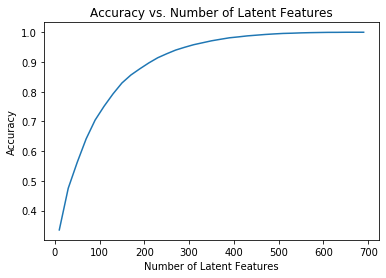

In [295]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [296]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = list(set(user_item_test.index))
    test_arts = list(set(user_item_test.columns))
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [297]:
user_item_train.shape, user_item_test.shape, len(test_idx), len(test_arts)

((4487, 714), (682, 574), 682, 574)

In [298]:
# How many users can we make predictions for in the test set?
print(len(set(user_item_test.index) & set(user_item_train.index)))

# How many users in the test set are we not able to make predictions for because of the cold start problem?
print(len(set(user_item_test.index) - set(user_item_train.index)))

# How many articles can we make predictions for in the test set?
print(len(set(user_item_test.columns) & set(user_item_train.columns)))

# How many articles in the test set are we not able to make predictions for because of the cold start problem?
print(len(set(user_item_test.columns) - set(user_item_train.columns)))

20
662
574
0


In [299]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [300]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # use the built in to get the three matrices

print(u_train.shape, s_train.shape, vt_train.shape, user_item_train.shape) # fit svd similar to above then use the cells below

(4487, 4487) (714,) (714, 714) (4487, 714)


In [312]:
train_idx = user_item_train.index
common_idx = list(set(train_idx) &set(test_idx))

In [303]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

In [301]:
# find the subset of calculatable users and article matrices
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

# Similarly, find the predictable subset of users and articles
test_users = set(user_item_train.index) & set(user_item_test.index)
test_articles = set(user_item_train.columns) & set(user_item_test.columns)
user_item_test_predictable = user_item_test.loc[test_users, test_articles]

num_latent_feats = np.arange(10,700+10,20)

squared_errors_train = []
squared_errors_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_pred = u_train_new.dot(s_train_new).dot(vt_train_new)
    user_item_test_pred = u_test_new.dot(s_train_new).dot(vt_test_new)
    
    # compute difference between predicted and actual value
    diffs_train = np.subtract(user_item_train, user_item_train_pred)
    diffs_test = np.subtract(user_item_test_predictable, user_item_test_pred)
    
    
    # calculate squared errors
    squared_errors_train.append((diffs_train**2).sum().sum())
    squared_errors_test.append((diffs_test**2).sum().sum())

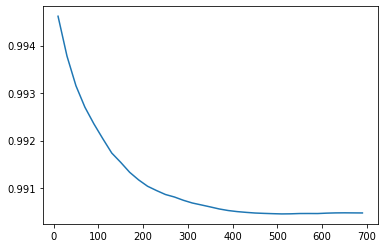

In [329]:
plt.plot(num_latent_feats, 1 - np.array(squared_errors_test)/df.shape[0])

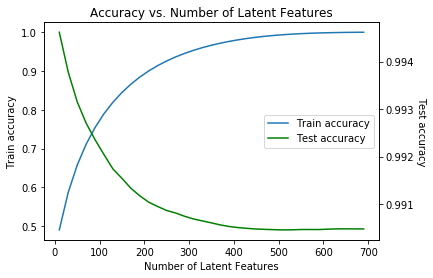

In [323]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(num_latent_feats, 1 - np.array(squared_errors_train)/df.shape[0], label="Train accuracy")
ax2.plot(num_latent_feats, 1 - np.array(squared_errors_test)/df.shape[0], color='green', label="Test accuracy")

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1+handler2, label1+label2, loc='center right')

ax1.set_title('Accuracy vs. Number of Latent Features')

ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Train accuracy')
ax2.set_ylabel('Test accuracy', rotation=270, labelpad=12)

plt.show()

Test accuracy decreases and train accuracy increases as well increase the number of latent features. The model shows overfitting beyond approximately 100 features, which is still effective for practical purposes since the test accuracy is very high, above 0.99.

To assess the impact of the new recommendation system(s), we can conduct tests e.g. A/B test, within-subjects test. This can help assess the effectiveness of the matrix, content-based, and rank-based systems.

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Test accuracy decreases and train accuracy increases as well increase the number of latent features. The model shows overfitting beyond approximately 100 features, which is still effective for practical purposes since the test accuracy is very high, above 0.99.**

**To assess the impact of the new recommendation system(s), we can conduct tests e.g. A/B test, within-subjects test. This can help assess the effectiveness of the matrix, content-based, and rank-based systems. Performance metrics include the rate of user interactions, time spend reading recommended and non-recommended articles, social media share rate, etc.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [884]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0